# Fake News Detction Model
* Author: Ji Hoon Chung

![Fakenews](Images/Fakenews.jpeg)

## Business Problem

We are living in an unprecedented era where we are easily being exposed to tons of news on social media which we did not intend to spot. From premature juveniles to mature adults with higher degrees of education, fake news could easily deprive their factual senses and having them fallen down to imperfect beliefs. <br>

Accordingly, it is crucial for social media platforms to detect fake news automatically to prohibit their exposure in the first place.<br>

Our clients are Social Media Platforms like Facebook, Twitter, and LinkedIn. I would like to introduce a machine learning model being able to classify fake news aside from actual news using the words and patterns that are prevalent in conventional news dataset.

## Overview

Dataset is obtained from source: https://drive.google.com/file/d/1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q/view <br>

I’ve collected a dataset which includes 6,335 rows of data containing 3,171 real news vs 3,164 fake news. Dataset is very straight forward containing only 3 columns such as, title, text (article contents), and label indicating real or fake.<br>

Machine Learning Model will be built after tweaking the dataset as below:
1. Text Data will be combined with Title.
2. 2nd column will be created with lemmmatized text.
3. 3rd column will be created with stemmed text.
4. Dataset will be resampled with 0.17:1.0 FAKE to REAL news ratio. (Real World Fake to Real news ratio)



# 1. Data Analysis

In [401]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import string
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud,STOPWORDS
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import inaugural, wordnet, stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer as w_tokenizer
from nltk.tag import pos_tag
from collections import Counter
from itertools import chain, filterfalse as ifilterfalse
from scipy import stats
import statsmodels
from statsmodels.formula.api import ols
warnings.filterwarnings('ignore')

## 1.1 Load & Clean Up Data

In [2]:
# Import Dataset
df = pd.read_csv("./data/news 2.csv")

In [3]:
# Dataset Overview
df.sample(10)

,Unnamed: 0,title,text,label
1489,2935,U.S. provides options for drawdown of forces i...,Washington (CNN) The top United States command...,REAL
3734,6402,WIKILEAKS BOMBSHELL : Chelsea Clinton Used Fou...,WIKILEAKS BOMBSHELL : Chelsea Clinton Used Fou...,FAKE
3131,10234,What to Expect From the New Congress,Email \nIn what Democrats and the Left hoped w...,FAKE
424,8146,Young Turks Finds Out Why Trump Is About To Lo...,"By Wes Williams Election 2016 , Politics , Vid...",FAKE
945,9977,Two Points About the Hillary Clinton Email Fiasco,Much is being made of Hillary Clinton’s privat...,FAKE
1480,3046,Why do people on the other side seem so unreas...,George W. Bush famously described himself as “...,REAL
5068,10319,Putin: Russia Is Not Going To Attack Anyone,Complaining about Western “hysteria” surroundi...,FAKE
1280,8223,Help Blow Up the Globalists Plot to Steal the ...,\n \nThe Benedict Arnold of the Republican Par...,FAKE
869,3848,Obama: Warren 'Absolutely Wrong' On Trade Deal,Elizabeth Warren announced a bill creating a F...,REAL
3130,6717,Jim Rogers: It’s Time To Prepare; Economic And...,By: The Voice of Reason | Regardless of how mu...,FAKE


It seems like most of the news are political within political category.

In [4]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Null value does not exist within the dataset.

In [5]:
# Combine Title into text and drop title from the dataframe.
df['text'] = df['title'] + df['text']
df.drop('title', inplace=True, axis=1)

In [6]:
# Text and Title are combined.
df.head()

,Unnamed: 0,text,label
0,8476,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathyU.S...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,875,The Battle of New York: Why This Primary Matte...,REAL


In [7]:
# Drop unnecessary columns.
df = df.drop(['Unnamed: 0'], axis=1)

## 1.2 Lemmatization & Stemming

For more detailed investigation on the text, I will prepare lemmatized & stemmed text dataset to see if these will bring better accuracy on our classification model later on.<br>

1. In lemmatization, the part of speech of a word should be first determined and the normalisation rules will be different for different part of speech, while the stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. <br>
<br>
2. A stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.
<br><br>
Source: https://stackoverflow.com/questions/1787110/what-is-the-difference-between-lemmatization-vs-stemming

### 1.2.1 Lemmatization

In [9]:
# Lemmatzie Fundtion after POS-TAG
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word

In [10]:
# Joining Lemmatized Text with a space.
def join_lemmatize(lem):
    return ' '.join(lem)

In [11]:
# Get the tokens lemmatized.
df['lemmatized_text'] = df['text'].apply((lemmatize_all))

In [12]:
# Construct lemmatized dataset.
df['lemmatized_text'] = df['lemmatized_text'].apply((join_lemmatize))

In [13]:
df.head()

,text,label,tokenized_sents,lemmatized_text
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE,"[You, Can, Smell, Hillary’s, FearDaniel, Green...",You Can Smell Hillary ’ s FearDaniel Greenfiel...
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,"[Watch, The, Exact, Moment, Paul, Ryan, Commit...",Watch The Exact Moment Paul Ryan Committed Pol...
2,Kerry to go to Paris in gesture of sympathyU.S...,REAL,"[Kerry, to, go, to, Paris, in, gesture, of, sy...",Kerry to go to Paris in gesture of sympathyU.S...
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,"[Bernie, supporters, on, Twitter, erupt, in, a...",Bernie supporter on Twitter erupt in anger aga...
4,The Battle of New York: Why This Primary Matte...,REAL,"[The, Battle, of, New, York:, Why, This, Prima...",The Battle of New York : Why This Primary Matt...


### 1.2.2 Stemming

In [ ]:
# Construct Tokenize Dataset
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
df['tokenized_sents'] = df.apply(lambda row: w_tokenizer.tokenize(row['text']), axis=1)

In [14]:
# Stemmer Function
def stemmer_text(text):
    ps = PorterStemmer()
    return [ps.stem(w) for w in text] 

In [15]:
# Consturct Stemmed dataset.
df['stemmer_text'] = df['tokenized_sents'].apply(stemmer_text)

In [17]:
def list_to_string(text):
    return ' '.join(str(e) for e in text)

In [18]:
# Convert List to String
df['stemmer_text'] = df['stemmer_text'].apply(list_to_string)

In [396]:
# Final Dataset for Model Building
df.head()

,text,label,tokenized_sents,lemmatized_text,stemmer_text,words_used,wordcount
0,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE,"[You, Can, Smell, Hillary’s, FearDaniel, Green...",You Can Smell Hillary ’ s FearDaniel Greenfiel...,"you can smell hillary’ feardaniel greenfield, ...",1300.0,"{'You': 2, 'Can': 1, 'Smell': 1, 'Hillary’s': ..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,"[Watch, The, Exact, Moment, Paul, Ryan, Commit...",Watch The Exact Moment Paul Ryan Committed Pol...,watch the exact moment paul ryan commit polit ...,459.0,"{'Watch': 1, 'The': 4, 'Exact': 1, 'Moment': 1..."
2,Kerry to go to Paris in gesture of sympathyU.S...,REAL,"[Kerry, to, go, to, Paris, in, gesture, of, sy...",Kerry to go to Paris in gesture of sympathyU.S...,kerri to go to pari in gestur of sympathyu.s. ...,439.0,"{'Kerry': 7, 'to': 17, 'go': 1, 'Paris': 6, 'i..."
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,"[Bernie, supporters, on, Twitter, erupt, in, a...",Bernie supporter on Twitter erupt in anger aga...,berni support on twitter erupt in anger agains...,418.0,"{'Bernie': 4, 'supporters': 2, 'on': 3, 'Twitt..."
4,The Battle of New York: Why This Primary Matte...,REAL,"[The, Battle, of, New, York:, Why, This, Prima...",The Battle of New York : Why This Primary Matt...,the battl of new york: whi thi primari matters...,325.0,"{'The': 1, 'Battle': 1, 'of': 6, 'New': 6, 'Yo..."


## 1.3 EDA

### 1.3.1 Text length comparison between FAKE vs. REAL News

In [20]:
df["words_used"] = np.nan

In [21]:
## See how may words are used per text
for i in range(len(df.text)-1):
    df['words_used'].iloc[i] = len(df['text'].iloc[i].split())

In [22]:
df_words = df.groupby('label').agg({'words_used':['mean', 'median', 'std', 'min', 'max']})

In [23]:
res = len(df['text'].iloc[1].split())

In [404]:
df_words.reset_index(inplace=True)

FAKE news articles contains less mean & median number of words whereas their standard deviation is a lot larger indicating they have more versatility in lengh of an article.

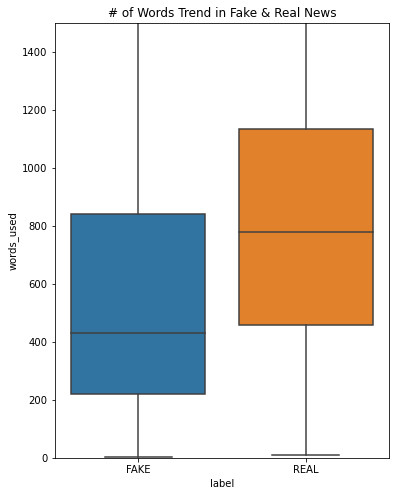

In [25]:
fig, ax = plt.subplots(figsize=(6,8))
ax = sns.boxplot(x='label', y='words_used', data=df)
ax.set_ylim(0,1500)
ax.set_title('# of Words Trend in Fake & Real News')
plt.savefig('./images/word_trend.png');

In [435]:
df.words_used.fillna(0, inplace=True)

In [436]:
# Conduct 2-Sample T-Test to see if we can reject null hypothesis.
stats.ttest_ind(df[df.label=='FAKE']['words_used'], df[df.label=='REAL']['words_used'])

Ttest_indResult(statistic=-9.021660039114863, pvalue=2.416269112428002e-19)

Overally, FAKE news has lower average length compared to REAL news. <br>
Since Two Sample T-Test shows significantly low p-value less than 0.05, we can reject the null hypothesis: <br>
<b>Number of words used is significantly related with the news article being FAKE or REAL.</b>

***

### 1.3.2 Word Cloud

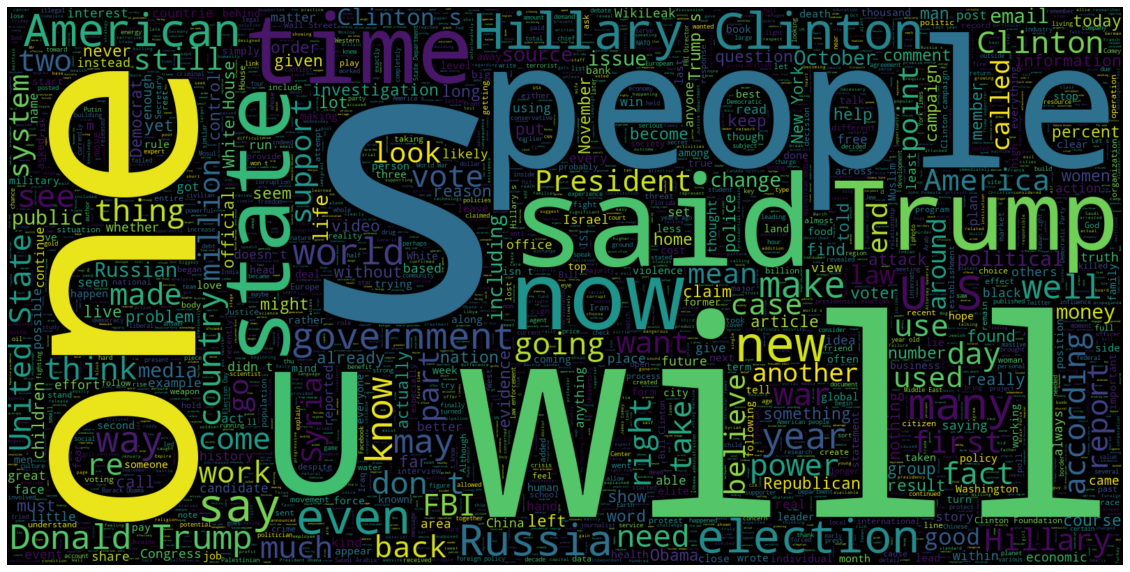

In [26]:
# Fake News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'FAKE'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show
plt.savefig('./images/Fake_wordcloud.png');

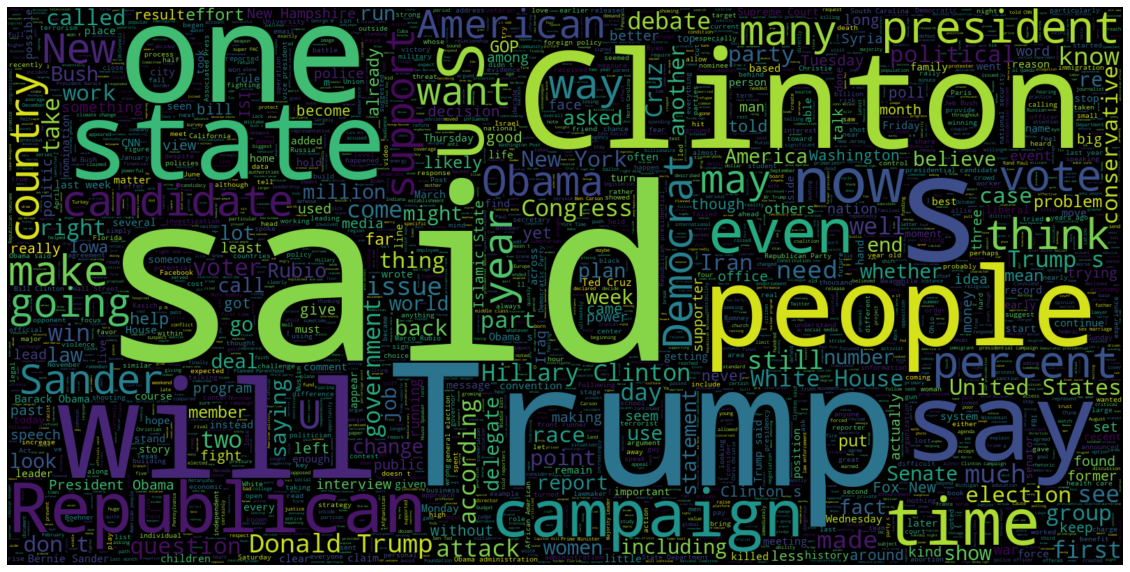

In [27]:
# Real News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'REAL'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show
plt.savefig('./images/Real_wordcloud.png');

Looking at word Cloud, it's hard to tell the distinction between two types of articles. However, it is evident that both articles are mainly about the US politics.

***

### 1.3.3 Top 10 Word Frequency Distribution Comparison

Since Wordcloud does not bring too much insightful information, let's try comparing Top 10 Word counts per Article Type using barplot.

In [303]:
# Count Words Function with the stopwords excluded from the count
def countwords(text):
    stops = stopwords.words('english')
    words = chain.from_iterable(line.split() for line in text)
    return Counter(word for word in words if word not in stops)

In [324]:
# Get Real News Word Count Dataset, change all text into lowercase to enable stopwords
df_real = df[df.label=='REAL']
df_real = df_real.text.str.lower()

In [294]:
# Get FAKE News Word Count Dataset, change all text into lowercase to enable stopwords
df_fake = df[df.label=='FAKE']
df_fake = df_fake.text.str.lower()

In [321]:
# Set Real News Word Counts
wordcount_real = countwords(df_real)

In [328]:
# Set FAKE News Word Counts
wordcount_fake = countwords(df_fake)

In [331]:
# Get the Top 10 most common words
wordcount_real = wordcount_real.most_common(10)
wordcount_fake = wordcount_fake.most_common(10)

In [344]:
# Retrieve X and Y values of the words and word counts
x_real = []
y_real = []

for i in range (10):
    x_real.append(wordcount_real[i][0])
    y_real.append(wordcount_real[i][1])
    
x_fake = []
y_fake = []

for i in range (10):
    x_fake.append(wordcount_fake[i][0])
    y_fake.append(wordcount_fake[i][1])

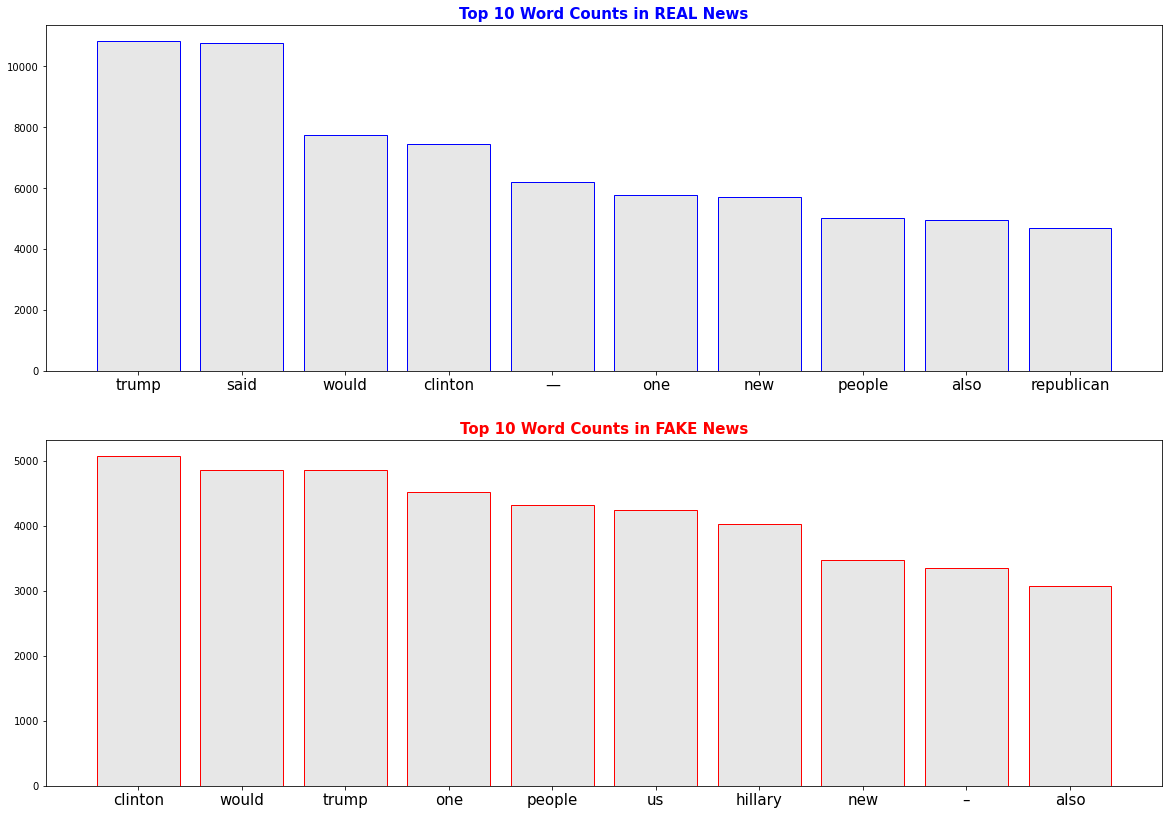

In [395]:
# Get the barplot of TOP 10 Word Counts for REAL & FAKE News.
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,14))

ax1.bar(x_real, y_real, color= (0.1, 0.1, 0.1, 0.1),  edgecolor='blue')
ax2.bar(x_fake, y_fake, color= (0.1, 0.1, 0.1, 0.1),  edgecolor='red')

ax1.set_title('Top 10 Word Counts in REAL News', fontdict = {'fontsize':15, 'fontweight':'bold', 'color':'blue'})
ax2.set_title('Top 10 Word Counts in FAKE News', fontdict = {'fontsize':15, 'fontweight':'bold', 'color':'red'})

ax1.tick_params(axis='x', which='major', labelsize=15)
ax2.tick_params(axis='x', which='major', labelsize=15)

plt.savefig('./images/Top10_WordCounts.png');

According to the Plot, there are a few notable differences between REAL & FAKE NEWS:
1. Trump was much widely used in REAL news whereas Clinton was more widely used in FAKE News.
2. It looks like FAKE news was more susceptible in using Full Name of Hilary Clinton.
3. 'US' was very widely used in FAKE news wheareas it was not one of the TOP 10 words in REAL news.

***

# 2. General Modeling

## 2.1 Splitting Dataset for Modeling.

In [ ]:
# Original Text X
X_text = df['text']

# Stemmed Text X
X_stem = df['stemmer_text']

#Lemmatized Text X
X_lem = df['lemmatized_text']

#Target Variable
y = df['label']

In [ ]:
y = pd.DataFrame(np.where(y=='FAKE', 1, 0))

In [ ]:
#DataFlair - Split the dataset (For Original Text)
x_text_train, x_text_test, y_text_train, y_text_test=train_test_split(X_text, y, test_size=0.2, random_state=7)

In [ ]:
#DataFlair - Split the dataset (For Stemmed Text)
x_stem_train, x_stem_test, y_stem_train, y_stem_test=train_test_split(X_stem, y, test_size=0.2, random_state=7)

In [ ]:
#DataFlair - Split the dataset (For Lemmatized Text)
x_lem_train, x_lem_test, y_lem_train, y_lem_test=train_test_split(X_lem, y, test_size=0.2, random_state=7)

## 2.2 Decision Tree Model (Without Adjusting Class Balance)

In [ ]:
# Build a pipeline with TfIDFVectorizer and Decision Tree Classifer
tree_tf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs1 = GridSearchCV(estimator=tree_tf_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

In [ ]:
# Build a pipeline with CountVectorizer and Decision Tree Classifer
tree_ct_pipeline = Pipeline([('vect',CountVectorizer()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs2 = GridSearchCV(estimator=tree_ct_pipeline, 
                          param_grid=grid, 
                          scoring='f1_micro', 
                          cv=5)

### 2.2.1 TFIDF Vectorizer Cross Validation Results

In [ ]:
# Using Original Text Dataset
gs1.fit(x_text_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

In [ ]:
# Using Lemmatized Text Dataset
gs1.fit(x_lem_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs1.fit(x_stem_train, y_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

For TfIDF Vectorizer, Best F1_Score came with the Stemmed Text Dataset

### 2.2.2 CountVectorizer Cross Validation Results

In [ ]:
# Using Original Text Dataset
gs2.fit(x_text_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs2.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs2.fit(x_stem_train, y_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

In [ ]:
# Using Lemmatized Text Dataset
gs2.fit(x_lem_train, y_text_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs1.best_score_)

For CountVectorizer, All the Datasets have to same F1_Score

### 2.2.3 Decision Tree Model Evaluation

<B>TFIDF Vectorizer with Stemmed Datasets showed best F1_Score in validation Score.

In [ ]:
# Predicting the model for tf-idf features
tree_tf_stem_pred = gs1.predict(x_stem_test)

In [ ]:
# Check the accuracy score for tfidf features
Tree_tfidf_score=accuracy_score(y_stem_test, tree_tf_stem_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfidf_score)

In [ ]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs1_x_test_tfidf = gs1.best_estimator_.named_steps['vect'].transform(x_stem_test)

In [ ]:
Tree_cm = plot_confusion_matrix(gs1.best_estimator_.named_steps['tree'], gs1_x_test_tfidf , y_stem_test)
plt.suptitle("Raw Data Decision Tree Confusion Matrix")
plt.savefig('./images/Raw_Tree_cf.png');

In [ ]:
Tree_roc = plot_roc_curve(gs1.best_estimator_.named_steps['tree'] ,gs1_x_test_tfidf, y_stem_test)
plt.suptitle("Raw Data Decision Tree ROC Curve")
plt.savefig('./images/Raw_Tree_ROC.png');

In [ ]:
Tree_tfidf_report = classification_report(y_test, Tree_tfidf_pred, target_names = ['FAKE','REAL'])
print(Tree_tfidf_report)

Accuray of model with the raw dataset seems pretty satisfying. However, class imbalance clearly exists between REAL vs FAKE news in Real World. Since my mission is to bring a model that can be fully utilized in real world, I will bring in class imbalance of target variable in the next section. 

***

## 3. Modeling After Setting Up Class Imbalance.

By the numbers: In 2020, nearly one-fifth <b>(17%)</b> of engagement among the top 100 news sources on social media came from sources that NewsGuard deems generally unreliable, compared to about 8% in 2019.<br>
<br>
Source = https://www.axios.com/unreliable-news-sources-social-media-engagement-297bf046-c1b0-4e69-9875-05443b1dca73.html?utm_campaign=organic&utm_medium=socialshare&utm_source=twitter

<B>Entire Dataset will be re-sampled into 0.17:1.0 FAKE to REAL news ratio so that it actually resembles FAKE news ratio being spread in the real world.

## 3.1 Resampling Dataset (0.17 : 1.0) FAKE to REAL

In [ ]:
from imblearn.datasets import make_imbalance

In [ ]:
# Original Text X
X_text = pd.DataFrame(X_text)

# Stemmed Text X
X_stem = pd.DataFrame(X_stem)

#Lemmatized Text X
X_lem = pd.DataFrame(X_lem)

In [ ]:
# Original Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_text, y_im_text = make_imbalance(X_text,y,sampling_strategy={1: 539, 0: 3171})

# Stemmed Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_stem, y_im_stem = make_imbalance(X_stem,y,sampling_strategy={1: 539, 0: 3171})

# Lemmatized Text, Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im_lem, y_im_lem = make_imbalance(X_lem,y,sampling_strategy={1: 539, 0: 3171})

In [ ]:
x_im_text = x_im_text['text']
x_im_stem = x_im_stem['stemmer_text']
x_im_lem = x_im_lem['lemmatized_text']

In [ ]:
#DataFlair - Split the dataset - Original text
x_im_train, x_im_test, y_im_train, y_im_test = train_test_split(x_im_text, y_im_text, test_size=0.2, random_state=7)

#DataFlair - Split the dataset - Stemmed text
x_im_stem_train, x_im_stem_test, y_im_stem_train, y_im_stem_test = train_test_split(x_im_stem, y_im_stem, test_size=0.2, random_state=7)

#DataFlair - Split the dataset - Lemmaitzed text
x_im_lem_train, x_im_lem_test, y_im_lem_train, y_im_lem_test = train_test_split(x_im_lem, y_im_lem, test_size=0.2, random_state=7)

Dataset & Splitting is Ready!

## 3.2 Dummy Model after resampling Dataset

Dummy Model needs to be constructed to evaluate performance going forward as Target Variable class is highly imbalanced.<br>
Model for only one of the datasets would be necessary as it is Dummy Classifier.

In [ ]:
# Build a pipeline with TFIDF and DummyClassifer
dummy_pipeline = Pipeline([('vect',TfidfVectorizer()),
                 ('dummy',DummyClassifier())])

# Define the grid
grid_3 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'dummy__strategy': ['most_frequent']}]

# Define a grid search
gs_3 = GridSearchCV(estimator=dummy_pipeline, 
                          param_grid=grid_3, 
                          scoring='f1_micro', 
                          cv=5)

In [ ]:
# Fit the training data
gs_3.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_3.best_score_)

In [ ]:
# Predicting the model for tf-idf features
dummy_pred = gs_3.predict(x_im_test)

In [ ]:
# Check the accuracy score for tfidf features
dummy_score=accuracy_score(y_im_test, dummy_pred)
print("Decision Tree TF-IDF accuracy score:", dummy_score)

In [ ]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs_3_x_test_tfidf = gs_3.best_estimator_.named_steps['vect'].transform(x_im_test)

In [ ]:
dummy_cm = plot_confusion_matrix(gs_3.best_estimator_.named_steps['dummy'], gs_3_x_test_tfidf, y_im_test)
plt.suptitle("Dummy Classifier Confusion Matrix")
plt.savefig('./images/Dummy_cf.png');

In [ ]:
dummy_report = classification_report(y_im_test, dummy_pred, target_names = ['0', '1'])
print(dummy_report)

<b>Since Dummy Score has Accuracy-Score of 0.857, our model should draw Accuracy Score at least better than 0.857.

## 3.3 Decision Tree Model after Data Split

In [ ]:
# Build a pipeline with TFIDF, SMOTE and Decision Tree Classifer, SMOTE was added to rebalance Training Data.
tree_pipeline_2 = Pipeline([('vect',TfidfVectorizer()),
                            ('smote', SMOTE()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid_4 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs_4 = GridSearchCV(estimator=tree_pipeline_2, 
                          param_grid=grid_4, 
                          scoring='f1_micro', 
                          cv=5)

In [ ]:
# Build a pipeline with TFIDF, SMOTE and CountVectorizer, SMOTE was added to rebalance Training Data.
tree_pipeline_3 = Pipeline([('vect',CountVectorizer()),
                            ('smote', SMOTE()),
                 ('tree',DecisionTreeClassifier())])

# Define the grid
grid_5 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'tree__max_depth': [8, 14, 20]}]

# Define a grid search
gs_5 = GridSearchCV(estimator=tree_pipeline_3, 
                          param_grid=grid_5, 
                          scoring='f1_micro', 
                          cv=5)

### 3.3.1 TFIDF Vectorizer Cross Validation Results

In [ ]:
# Using Lemmatized Text Dataset
gs_4.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_4.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4.best_score_)

In [ ]:
# Using Original Text Dataset
gs_4.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_4.best_score_)

### 3.3.2 CountVectorizer Cross Validation Results

In [ ]:
# Using Original Text Dataset
gs_5.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5.best_score_)

In [ ]:
# Using Lemmatized Text Dataset
gs_5.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_5.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_5.best_score_)

### 3.3.3 Decision Tree Model Evaluation

In [ ]:
# Predicting the model for tf-idf features
tree_tf_imb_pred = gs_4.predict(x_im_test)

In [ ]:
# Check the accuracy score for tfidf features
Tree_tfimb_score=accuracy_score(y_im_test, tree_tf_imb_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfimb_score)

In [ ]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs4_x_test_tfimb = gs_4.best_estimator_.named_steps['vect'].transform(x_im_test)

In [ ]:
Tree_imb_cm = plot_confusion_matrix(gs_4.best_estimator_.named_steps['tree'], gs4_x_test_tfimb , y_im_test)
plt.suptitle("Imbalance Data DecisionTree Confusion Matrix")
plt.savefig('./images/Imb_Tree_cf.png');

In [ ]:
Tree_imb_roc = plot_roc_curve(gs_4.best_estimator_.named_steps['tree'] ,gs4_x_test_tfimb, y_im_test)
plt.suptitle("Imbalance Data DecisionTree ROC Curve")
plt.savefig('./images/Imb_Tree_ROC.png');

In [ ]:
Tree_tfimb_report = classification_report(y_im_test, tree_tf_imb_pred, target_names = ['0','1'])
print(Tree_tfimb_report)

Accuracy Score is better than DummyClassifier at 0.869 which is <b>0.012</b> higher than DummyClassifer.<br>
However, we could do better than this.

## 3.4 RandomForest Model after Data Split


In [ ]:
# Build a pipeline with TFIDF and RandomForestClassifier
rdf_pipeline = Pipeline([('vect',TfidfVectorizer()),
                         ('smote', SMOTE()),
                 ('rdf',RandomForestClassifier())])

# Define the grid
grid_6 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'rdf__n_estimators': [10, 20, 30, 40]}]

# Define a grid search
gs_6 = GridSearchCV(estimator=rdf_pipeline, 
                          param_grid=grid_6, 
                          scoring='f1_micro', 
                          cv=5)

In [ ]:
# Build a pipeline with CountVectorizer and RandomForestClassifier
rdf_pipeline2 = Pipeline([('vect',CountVectorizer()),
                          ('smote', SMOTE()),
                 ('rdf',RandomForestClassifier())])

# Define the grid
grid_7 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'rdf__n_estimators': [10, 20, 30, 40]}]

# Define a grid search
gs_7 = GridSearchCV(estimator=rdf_pipeline2, 
                          param_grid=grid_7, 
                          scoring='f1_micro', 
                          cv=5)

### 3.4.1 TFIDF Vectorizer Cross Validation Results

In [ ]:
# Using Lemmatized Text Dataset
gs_6.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_6.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_6.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_6.best_score_)

In [ ]:
# Using Original Text Dataset
gs_6.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_6.best_score_)

### 3.4.2 CountVectorizer Cross Validation Results

In [ ]:
# Using Original Text Dataset
gs_7.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_7.best_score_)

In [ ]:
# Using Lemmatized Text Dataset
gs_7.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_7.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_7.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_7.best_score_)

### 3.4.3 RandomForest Model Evaluation

In [ ]:
# Predicting the model for tf-idf features
dec_imb_pred = gs_6.predict(x_im_test)

In [ ]:
# Check the accuracy score for tfidf features
dec_imb_score=accuracy_score(y_im_test, dec_imb_pred)
print("RandomForest TF-IDF accuracy score:", dec_imb_score)

In [ ]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs6_rf_tfidf = gs_6.best_estimator_.named_steps['vect'].transform(x_im_test)

In [ ]:
rfb_cm = plot_confusion_matrix(gs_6.best_estimator_.named_steps['rdf'], gs6_rf_tfidf , y_im_test)
plt.suptitle("Imbalance Data RandomForest Confusion Matrix")
plt.savefig('./images/Imb_RF_cf.png');

In [ ]:
rfb_roc = plot_roc_curve(gs_6.best_estimator_.named_steps['rdf'] ,gs6_rf_tfidf, y_im_test)
plt.suptitle("Imbalance Data RandomForest ROC Curve")
plt.savefig('./images/Imb_RF_ROC.png');

In [ ]:
rfb_report = classification_report(y_im_test, dec_imb_pred, target_names = ['0','1'])
print(rfb_report)

Accuracy Score is high. However in terms of Fake News F1-Score it is lower than DecisionTree model. We would need a better model.

## 3.5 Multinomial Model after Data Split

In [ ]:
# Build a pipeline with TFIDF and MultinomialClassifier
mlb_pipeline = Pipeline([('vect',TfidfVectorizer()),
                         ('smote', SMOTE()),
                 ('mlb',MultinomialNB())])

# Define the grid
grid_8 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],}]

# Define a grid search
gs_8 = GridSearchCV(estimator=mlb_pipeline, 
                          param_grid=grid_8, 
                          scoring='f1_micro', 
                          cv=5)

In [ ]:
# Build a pipeline with CountVectorizer and MultinomialClassifier
mlb_pipeline2 = Pipeline([('vect',CountVectorizer()),
                         ('smote', SMOTE()),
                 ('mlb',MultinomialNB())])

# Define the grid
grid_9 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],}]

# Define a grid search
gs_9 = GridSearchCV(estimator=mlb_pipeline2, 
                          param_grid=grid_9, 
                          scoring='f1_micro', 
                          cv=5)

### 3.5.1 TFIDF Vectorizer Cross Validation Results

In [ ]:
# Using Lemmatized Text Dataset
gs_8.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_8.best_score_)

In [ ]:
# Using Original Text Dataset
gs_8.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_8.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_8.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_8.best_score_)

### 3.5.2 CountVectorizer Cross Validation Results

In [ ]:
# Using Original Text Dataset
gs_9.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9.best_score_)

In [ ]:
# Using Lemmatized Text Dataset
gs_9.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_9.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9.best_score_)

### 3.5.3 MultiNomial Model Evaluation

Stemmed TFIDF Vectorizor is the best model according to CV.

In [ ]:
# Predicting the model for tf-idf features
mlb_imb_pred = gs_8.predict(x_im_stem_test)

In [ ]:
# Check the accuracy score for tfidf features
mlb_imb_score=accuracy_score(y_im_stem_test, mlb_imb_pred)
print("RandomForest TF-IDF accuracy score:", mlb_imb_score)

In [ ]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs8_mlb_tfidf = gs_8.best_estimator_.named_steps['vect'].transform(x_im_stem_test)

In [ ]:
mlb_cm = plot_confusion_matrix(gs_8.best_estimator_.named_steps['mlb'], gs8_mlb_tfidf , y_im_stem_test)
plt.suptitle("Imbalance Data MultiNomial Confusion Matrix")
plt.savefig('./images/Imb_MNB_CF.png');

In [ ]:
mlb_roc = plot_roc_curve(gs_8.best_estimator_.named_steps['mlb'] ,gs8_mlb_tfidf, y_im_stem_test)
plt.suptitle("Imbalance Data MultiNomial ROC Curve")
plt.savefig('./images/Imb_MNB_ROC.png');

In [ ]:
mlb_report = classification_report(y_im_stem_test, mlb_imb_pred, target_names = ['0','1'])
print(mlb_report)

Multinomial model is definitely much more terrific than all the previous models!

## 3.6 PassiveAggressiveClassifier Model after Data Split

In [ ]:
# Build a pipeline with TFIDF and MultinomialClassifier
pac_pipeline = Pipeline([('vect',TfidfVectorizer()),
                         ('smote', SMOTE()),
                 ('pac',PassiveAggressiveClassifier())])

# Define the grid
grid_10 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'pac__max_iter': [50, 200, 500, 1000]}]

# Define a grid search
gs_10 = GridSearchCV(estimator=pac_pipeline, 
                          param_grid=grid_10, 
                          scoring='f1_micro', 
                          cv=5)

In [ ]:
# Build a pipeline with TFIDF and MultinomialClassifier
pac_pipeline2 = Pipeline([('vect',CountVectorizer()),
                         ('smote', SMOTE()),
                 ('pac',PassiveAggressiveClassifier())])

# Define the grid
grid_11 = [{'vect__stop_words': ['english'],
         'vect__max_df': [0.7, 0.8],
         'vect__min_df': [0, 0.5, 1.0],
         'pac__max_iter': [50, 200, 500, 1000]}]

# Define a grid search
gs_11 = GridSearchCV(estimator=pac_pipeline2, 
                          param_grid=grid_11, 
                          scoring='f1_micro', 
                          cv=5)

### 3.6.1 TFIDF Vectorizer Cross Validation Results

In [ ]:
# Using Original Text Dataset
gs_10.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_10.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_10.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_10.best_score_)

In [ ]:
# Using Lemmatized Text Dataset
gs_10.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_10.best_score_)

### 3.6.2 CountVectorizer Cross Validation Results

In [ ]:
# Using Original Text Dataset
gs_9.fit(x_im_train, y_im_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9.best_score_)

In [ ]:
# Using Lemmatized Text Dataset
gs_9.fit(x_im_lem_train, y_im_lem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9.best_score_)

In [ ]:
# Using Stemmed Text Dataset
gs_9.fit(x_im_stem_train, y_im_stem_train)

# Best accuracy
print('Best F1_Score: %.3f' % gs_9.best_score_)

### 3.6.3 PassiveAggressiveClassifer Model Evaluation

Lemmatized TFIDF Vectorizor is the best model according to CV.

In [ ]:
# Predicting the model for tf-idf features
pac_imb_pred = gs_10.predict(x_im_lem_test)

In [ ]:
# Check the accuracy score for tfidf features
pac_imb_score=accuracy_score(y_im_lem_test, pac_imb_pred)
print("RandomForest TF-IDF accuracy score:", pac_imb_score)

In [ ]:
# Set x_teset_tfidf value for Confusion Matrix Evaluation
gs10_pac_tfidf = gs_10.best_estimator_.named_steps['vect'].transform(x_im_lem_test)

In [ ]:
pac_cm = plot_confusion_matrix(gs_10.best_estimator_.named_steps['pac'], gs10_pac_tfidf , y_im_lem_test)
plt.suptitle("Imbalance Data PassiveAggressive Confusion Matrix")
plt.savefig('./images/Imb_Pac_CF.png');

In [ ]:
pac_roc = plot_roc_curve(gs_10.best_estimator_.named_steps['pac'] ,gs10_pac_tfidf, y_im_lem_test)
plt.suptitle("Imbalance Data PassiveAggressive ROC Curve")
plt.savefig('./images/Imb_PAC_ROC.png');

In [ ]:
pac_report = classification_report(y_im_lem_test, pac_imb_pred, target_names = ['0','1'])
print(pac_report)

PassiveAgressive Model is doing great as well, but MultinomialClassifier model is slightly better.

***

## Conclusion

Although PassiveAggressive Model was a strong competitior, I concluded that MultinomialNB model being the optimal model for our dataset.<br>
Compared to PassiveAggresive Model, MultinomialNB model was better in:
1. Higher Accuracy & F1-Score
2. Classified higher # of Fake News
3. Classified higher # of Real News
4. Lower False Negative 


Sine MultinomialNB classifier is built to be suitable for classification with word counts for text classification, it is not a surprise that MultinomialNB was the optimal classifier.

***

## Ideas for Improvement

1. Try Unsupervised Learning Models. (Deep Learning)
2. Try Web-Scraping from Fake News sites like Onions and see how well our model performs.
3. Try Web-Scraping from Social Media and see the Fake News Detection Rate.
